# Modeling

In [52]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# SMOTE
from imblearn.over_sampling import SMOTE

# visualizations 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
%matplotlib inline

In [53]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [54]:
# importing our corpues i.e., our processed tokens
corpus = pd.read_csv('data/spotify-reviews.csv')
corpus = corpus.rename(columns={'review':'tokens'})
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
spotify_reviews = pd.concat([spotify_df,corpus],axis=1)

In [55]:
data = spotify_reviews[spotify_reviews.sentiment.isin(['pos','neg'])]
data.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play


In [56]:
# instantiating our label encoder so that we can label our classes
label_enc = LabelEncoder()

In [57]:
X = data.tokens
y = data.sentiment
y = label_enc.fit_transform(y)

In [58]:
# looking at our class distribution 
data.sentiment.value_counts(normalize=True)

pos    0.695899
neg    0.304101
Name: sentiment, dtype: float64

In [59]:
# for more detailed labels later on 
class_labels = ['Negative','Positive']

In [60]:
# splitting our data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [61]:
# creating a pipeline for our vectorizer 
pre_process_steps = [('tfdif', TfidfVectorizer())]
preprocess_pipeline = Pipeline(pre_process_steps)
preprocess_pipeline

Pipeline(steps=[('tfdif', TfidfVectorizer())])

## Creating a Baseline DummyClassifier Model

To evaluate our future models, we'll use `DummyClasifier` and calculate the `PR-AUC` of each iterative model to isolate the highest performing model. 

In [63]:
from sklearn.dummy import DummyClassifier

In [64]:
dummy_pipe = deepcopy(preprocess_pipeline)
dummy_pipe.steps.append(('dummy_clf',DummyClassifier(random_state=42)))
dummy_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('dummy_clf', DummyClassifier(random_state=42))])

In [65]:
# fitting our pipeline on the training data 
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('dummy_clf', DummyClassifier(random_state=42))])

In [66]:
#extracting our predictions 
preds = dummy_pipe.predict(X_test)

### Confusion-Matrix Display

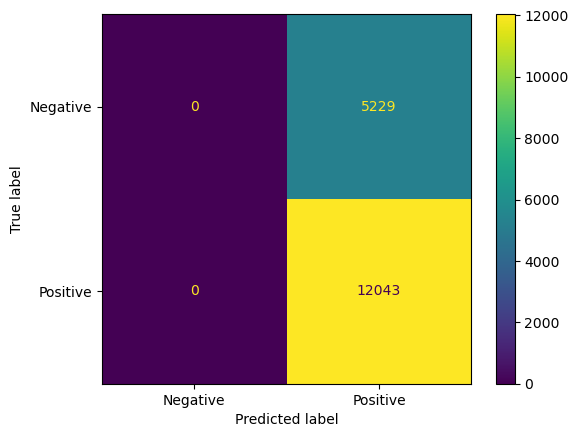

In [67]:
# creating a confusion matrix for our baseline dummy model 
ConfusionMatrixDisplay.from_predictions(y_test,preds,display_labels=['Negative','Positive'])

In [68]:
dummy_pipe.score(X_test,y_test)

0.6972556739231126

### Precision-Recall AUC (PR-AUC)

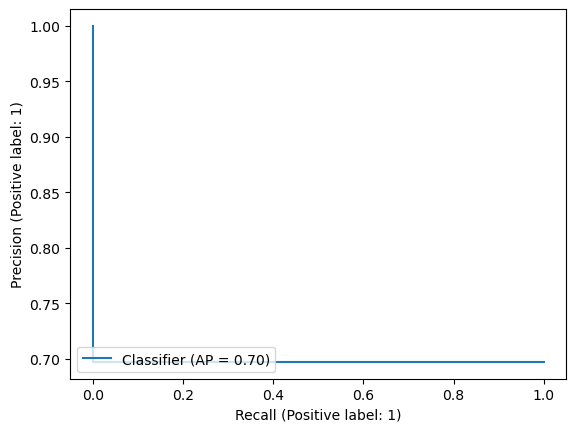

In [69]:
# plotting the precision-recall curve 
PrecisionRecallDisplay.from_predictions(y_test, preds)

### ROC-AUC Curve

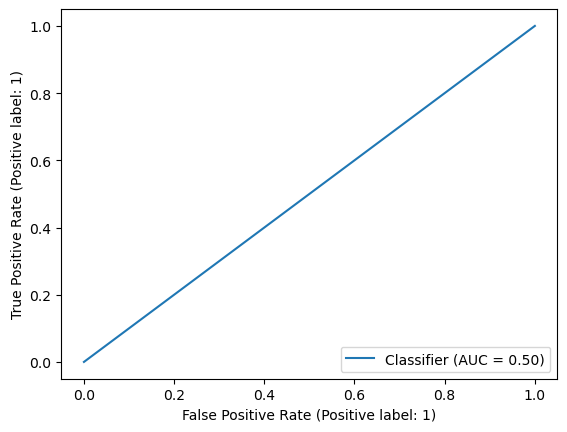

In [70]:
RocCurveDisplay.from_predictions(y_test, preds)

### Classification Report

In [71]:
print(classification_report(y_test,preds,target_names=class_labels,zero_division=1))

              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      5229
    Positive       0.70      1.00      0.82     12043

    accuracy                           0.70     17272
   macro avg       0.85      0.50      0.41     17272
weighted avg       0.79      0.70      0.57     17272



Our dummy model has a baseline accuracy of 70%, which is okay. 

## RandomForestClassifier

For our first model, we'll use `RandomForestClassifier`!

In [72]:
#imports
from sklearn.ensemble import RandomForestClassifier

In [73]:
rf_pipe = deepcopy(preprocess_pipeline)
rf_pipe.steps.append(('rf_clf',RandomForestClassifier(random_state=42)))
rf_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [74]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [75]:
# extracting our predictions 
preds2 = rf_pipe.predict(X_test)

### Confusion Matrix Display

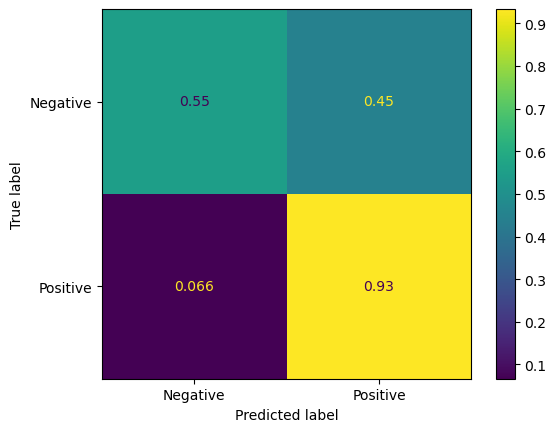

In [76]:
ConfusionMatrixDisplay.from_predictions(y_test, preds2,normalize='true',display_labels=class_labels)

In [77]:
rf_pipe.score(X_test,y_test)

0.818723946271422

### Classification Report 

In [78]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.78      0.55      0.65      5229
           1       0.83      0.93      0.88     12043

    accuracy                           0.82     17272
   macro avg       0.81      0.74      0.76     17272
weighted avg       0.81      0.82      0.81     17272



### ROC 

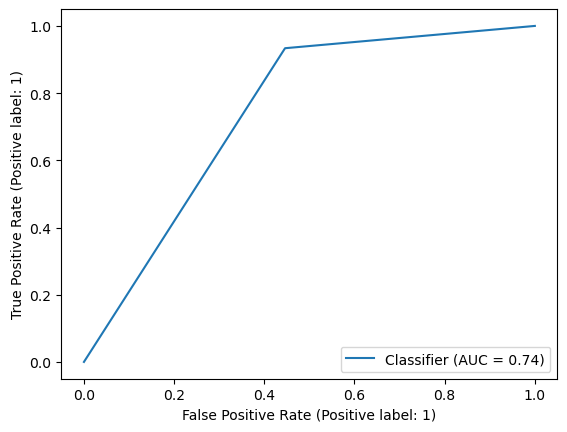

In [79]:
RocCurveDisplay.from_predictions(y_test,preds2)

### Precision-Recall Curve

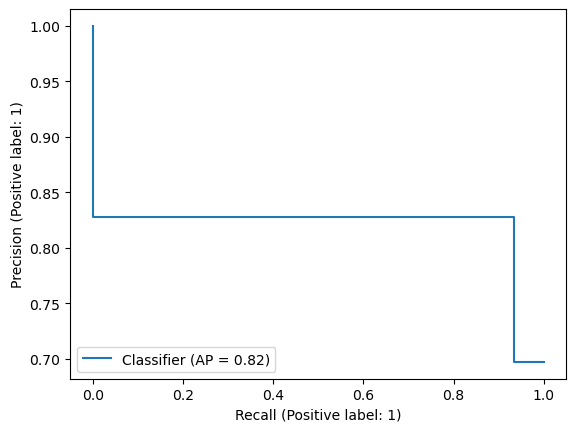

In [80]:
PrecisionRecallDisplay.from_predictions(y_test,preds2)

## Model Tuning

In [81]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [82]:
rf_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                 'tfdif__max_df':[.85,.90,.95],
                 'rf_clf__n_estimators':[50,100,150],
                 'rf_clf__max_features':[1e-2,1e-1,1]}

In [83]:
# avg run-time : 28 min
rf_random_cv = RandomizedSearchCV(estimator=rf_pipe,
                               param_distributions=rf_rcv_params,
                               cv=5)
rf_random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('rf_clf',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'rf_clf__max_features': [0.01, 0.1, 1],
                                        'rf_clf__n_estimators': [50, 100, 150],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [84]:
best_rf_preds = rf_random_cv.predict(X_test)

### Classification Report

In [85]:
print(classification_report(y_test,best_rf_preds))

              precision    recall  f1-score   support

           0       0.74      0.49      0.59      5229
           1       0.81      0.93      0.86     12043

    accuracy                           0.79     17272
   macro avg       0.77      0.71      0.73     17272
weighted avg       0.79      0.79      0.78     17272



### ROC-AUC Curve

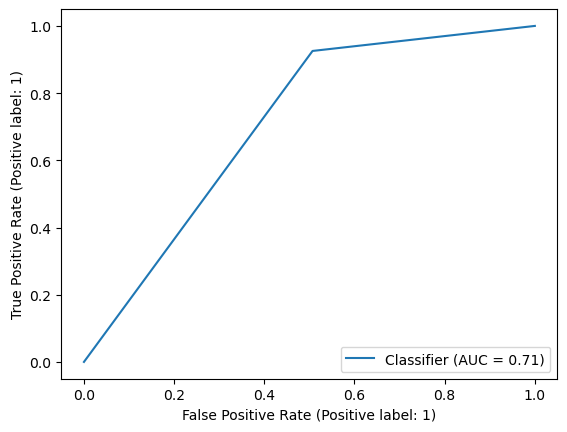

In [86]:
RocCurveDisplay.from_predictions(y_test,best_rf_preds)

### Precision-Recall Curve

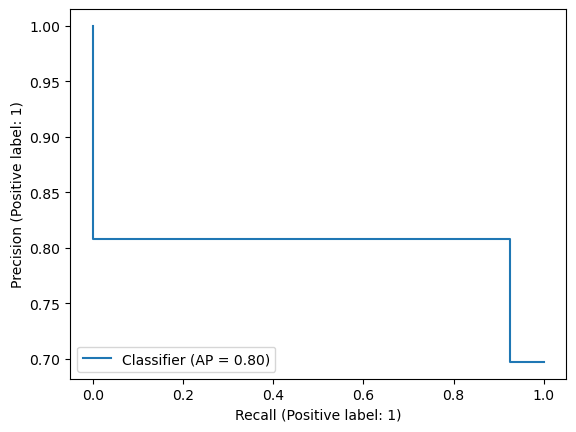

In [87]:
PrecisionRecallDisplay.from_predictions(y_test,best_rf_preds)

## Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
log_pipe = deepcopy(preprocess_pipeline)
log_pipe.steps.append(('log_reg',LogisticRegression(random_state=418)))
log_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('log_reg', LogisticRegression(random_state=418))])

In [90]:
log_pipe.fit(X_train,y_train)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('log_reg', LogisticRegression(random_state=418))])

Our model with default params did not converge! In our model-tuning steps, we'll use `RandomziedSearchCV` to optimize for different `max_iters`.

In [91]:
accuracy_score(y_test,preds3)

0.853520148216767

In [92]:
preds3 = log_pipe.predict(X_test)

### Confusion  Matrix Display

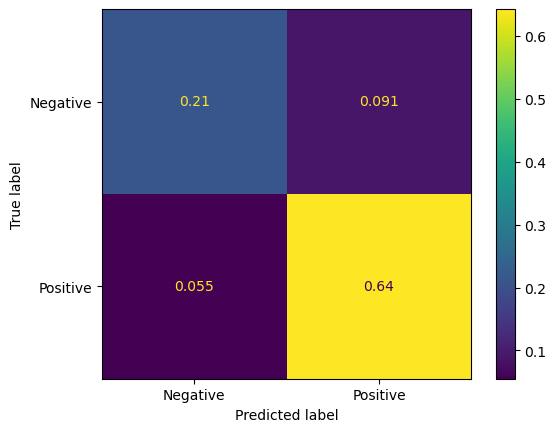

In [93]:
ConfusionMatrixDisplay.from_predictions(y_test, preds3,normalize='all',display_labels=class_labels)

### Classification Report

In [94]:
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5229
           1       0.88      0.92      0.90     12043

    accuracy                           0.85     17272
   macro avg       0.83      0.81      0.82     17272
weighted avg       0.85      0.85      0.85     17272



### ROC 

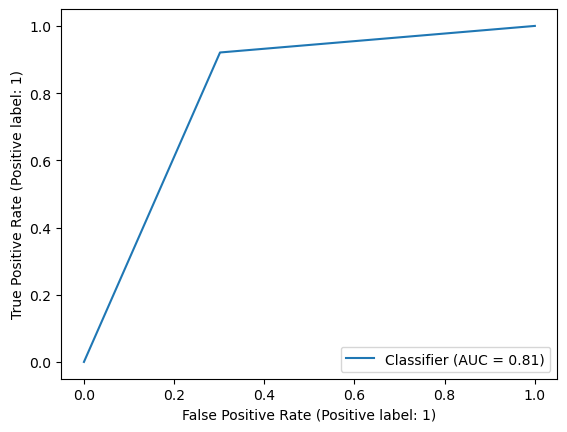

In [95]:
RocCurveDisplay.from_predictions(y_test,preds3)

### Precision-Recall Curve

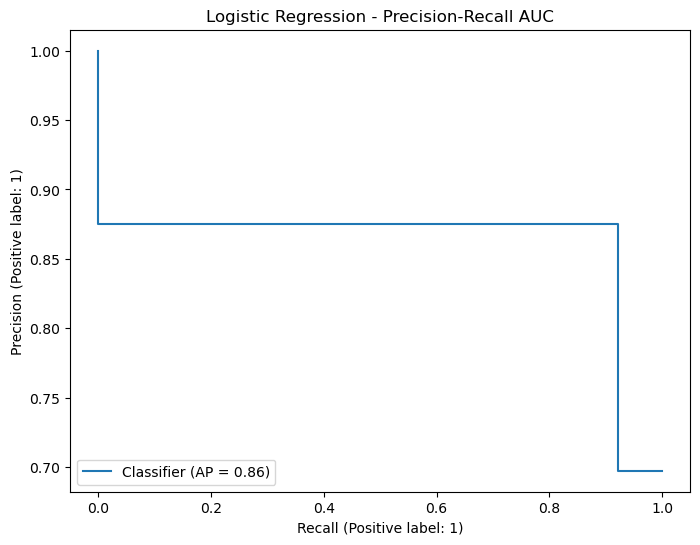

In [96]:
fig,ax = plt.subplots(figsize=(8,6))
ax = PrecisionRecallDisplay.from_predictions(y_test,preds3,ax=ax)
plt.title("Logistic Regression - Precision-Recall AUC")
plt.tight_layout
plt.savefig('images/log_model_pr_auc.png',dpi=300)

## Hyperparameter Tuning

In [97]:
log_pipe.steps

[('tfdif', TfidfVectorizer()),
 ('log_reg', LogisticRegression(random_state=418))]

In [98]:
random_cv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'log_reg__C':[1e-3,1e-2,1e-1,1,1.01,1.1,1e1],
                    'log_reg__max_iter':[100,120,140]}

In [99]:
random_cv = RandomizedSearchCV(estimator=log_pipe,
                               param_distributions=random_cv_params,
                               cv=5)
random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('log_reg',
                                              LogisticRegression(random_state=418))]),
                   param_distributions={'log_reg__C': [0.001, 0.01, 0.1, 1,
                                                       1.01, 1.1, 10.0],
                                        'log_reg__max_iter': [100, 120, 140],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [100]:
best_log_preds = random_cv.best_estimator_.predict(X_test)

### Classification Report

In [101]:
print(classification_report(y_test,best_log_preds))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67      5229
           1       0.85      0.89      0.87     12043

    accuracy                           0.81     17272
   macro avg       0.78      0.76      0.77     17272
weighted avg       0.81      0.81      0.81     17272



### ROC-AUC Curve

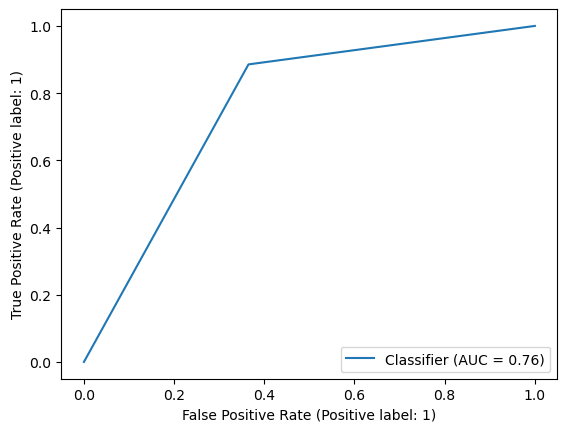

In [102]:
RocCurveDisplay.from_predictions(y_test,best_log_preds)

### Precision-Recall Curve

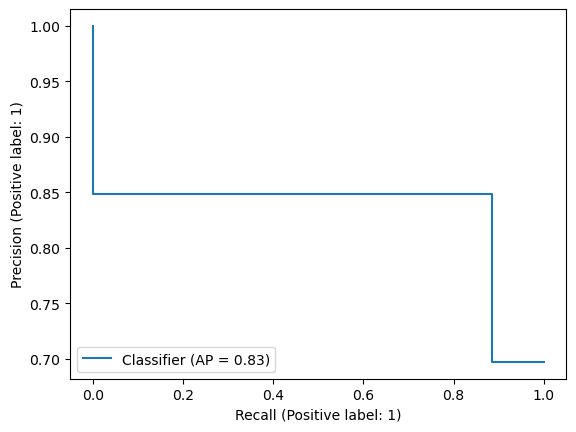

In [103]:
PrecisionRecallDisplay.from_predictions(y_test,best_log_preds)

In [104]:
pd.DataFrame(random_cv.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfdif__min_df,param_tfdif__max_df,param_log_reg__max_iter,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.584230,0.033197,0.113298,0.004160,0.01,0.95,140,10.0,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.95,...",0.805235,0.807196,0.812779,0.818859,0.818610,0.812536,0.005635,1
0,0.516133,0.024497,0.118544,0.007941,0.03,0.95,140,1,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.95,...",0.769259,0.769727,0.771216,0.778040,0.778660,0.773380,0.004113,2
2,0.518322,0.018624,0.117114,0.005020,0.03,0.95,100,1.1,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.95,...",0.769383,0.769851,0.771216,0.777543,0.778784,0.773356,0.003991,3
4,0.524258,0.015987,0.118375,0.005127,0.03,0.95,100,1.01,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.95,...",0.769508,0.769603,0.771216,0.777792,0.778660,0.773356,0.004032,4
6,0.472249,0.006325,0.118663,0.005538,0.05,0.9,120,1.01,"{'tfdif__min_df': 0.05, 'tfdif__max_df': 0.9, ...",0.742216,0.746774,0.747395,0.749380,0.752481,0.747649,0.003367,5


The results from `RandomizedSearchCV` did not improve model performance. 

## Multinomial Naive Bayes

In [105]:
from sklearn.naive_bayes import MultinomialNB

In [106]:
multiNB_pipe = deepcopy(preprocess_pipeline)
multiNB_pipe.steps.append(('multiNB',MultinomialNB()))
multiNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('multiNB', MultinomialNB())])

In [107]:
multiNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('multiNB', MultinomialNB())])

In [108]:
preds4 = multiNB_pipe.predict(X_test)

### Classification Report 

In [109]:
print(classification_report(y_test, preds4))

              precision    recall  f1-score   support

           0       0.78      0.36      0.49      5229
           1       0.77      0.96      0.86     12043

    accuracy                           0.78     17272
   macro avg       0.78      0.66      0.67     17272
weighted avg       0.78      0.78      0.75     17272



### Confusion Matrix Display

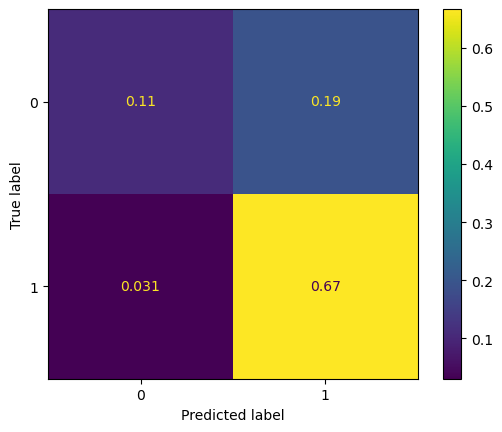

In [110]:
ConfusionMatrixDisplay.from_predictions(y_test, preds4,normalize='all')

### ROC-AUC Curve

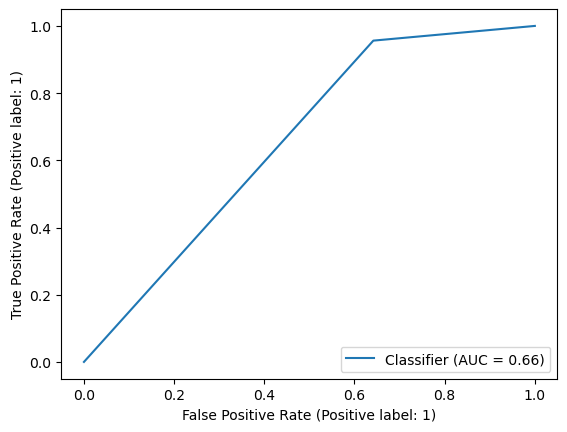

In [111]:
RocCurveDisplay.from_predictions(y_test,preds4)

### Precision-Recall Curve

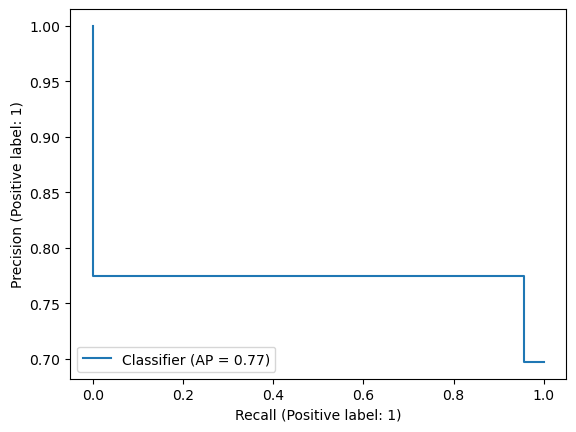

In [112]:
PrecisionRecallDisplay.from_predictions(y_test,preds4)

## Hyperparameter Tuning

In [113]:
multinb_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'multiNB__alpha':[1e-2, 1e-1, 1, 1e1,1e2]}

In [114]:
multinb_rcv_pipe = RandomizedSearchCV(estimator=multiNB_pipe,
                               param_distributions=multinb_rcv_params,
                               cv=5)

In [115]:
multinb_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('multiNB', MultinomialNB())]),
                   param_distributions={'multiNB__alpha': [0.01, 0.1, 1, 10.0,
                                                           100.0],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [116]:
best_multinb_preds = multinb_rcv_pipe.predict(X_test)

In [117]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

### Classification Report

In [118]:
print(classification_report(y_test,best_multinb_preds))

              precision    recall  f1-score   support

           0       0.68      0.44      0.53      5229
           1       0.79      0.91      0.85     12043

    accuracy                           0.77     17272
   macro avg       0.74      0.67      0.69     17272
weighted avg       0.76      0.77      0.75     17272



### ROC-AUC Curve

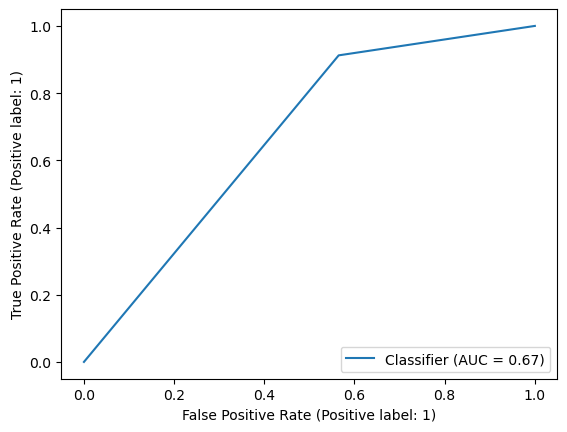

In [119]:
RocCurveDisplay.from_predictions(y_test,best_multinb_preds)

### Precision-Recall Curve

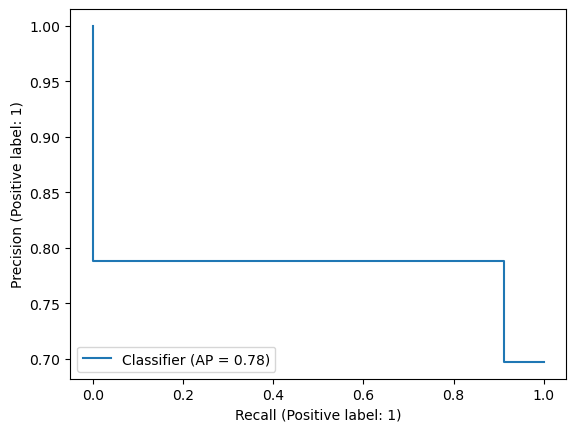

In [120]:
PrecisionRecallDisplay.from_predictions(y_test,best_multinb_preds)

## Complement Naive Bayes

In [121]:
from sklearn.naive_bayes import ComplementNB

In [122]:
compNB_pipe = deepcopy(preprocess_pipeline)
compNB_pipe.steps.append(('compNB',ComplementNB()))
compNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('compNB', ComplementNB())])

In [123]:
compNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('compNB', ComplementNB())])

In [124]:
preds5 = compNB_pipe.predict(X_test)

In [125]:
print(classification_report(y_test, preds5))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      5229
           1       0.88      0.81      0.84     12043

    accuracy                           0.79     17272
   macro avg       0.76      0.78      0.77     17272
weighted avg       0.81      0.79      0.80     17272



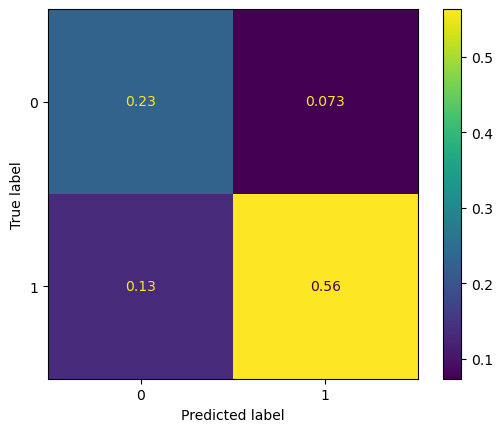

In [126]:
ConfusionMatrixDisplay.from_predictions(y_test, preds5,normalize='all')

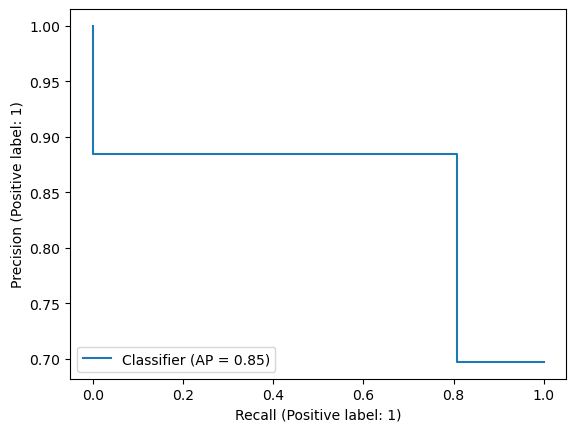

In [127]:
PrecisionRecallDisplay.from_predictions(y_test,preds5)

## Hyperparameter Tuning

In [128]:
compNB_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'compNB__alpha':[1e-2, 1e-1, 1, 1e1,1e2]}

In [129]:
compNB_rcv_pipe = RandomizedSearchCV(estimator=compNB_pipe,
                               param_distributions=compNB_rcv_params,
                               cv=5)

In [130]:
compNB_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('compNB', ComplementNB())]),
                   param_distributions={'compNB__alpha': [0.01, 0.1, 1, 10.0,
                                                          100.0],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [131]:
best_compNB_preds = compNB_rcv_pipe.predict(X_test)

### Classification Report

In [132]:
print(classification_report(y_test,best_compNB_preds))

              precision    recall  f1-score   support

           0       0.57      0.78      0.65      5229
           1       0.88      0.74      0.81     12043

    accuracy                           0.75     17272
   macro avg       0.72      0.76      0.73     17272
weighted avg       0.79      0.75      0.76     17272



### ROC-AUC Curve

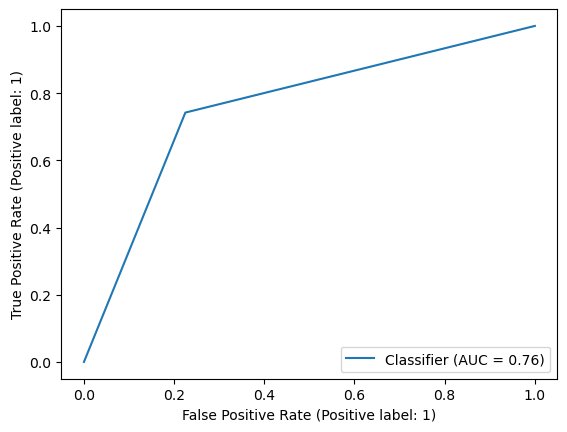

In [133]:
RocCurveDisplay.from_predictions(y_test,best_compNB_preds)

### Precision-Recall Curve

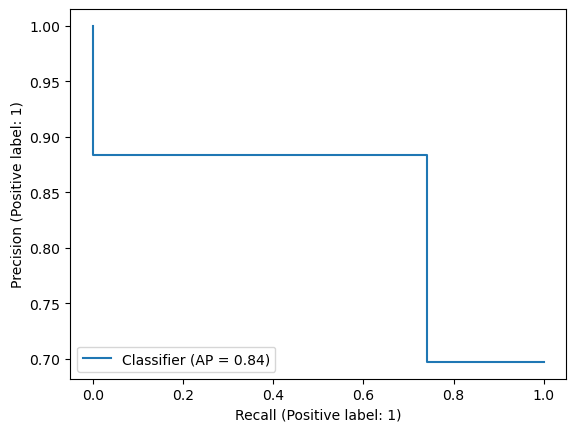

In [134]:
PrecisionRecallDisplay.from_predictions(y_test,best_compNB_preds)

## Bernoulli Naive Bayes

In [135]:
from sklearn.naive_bayes import BernoulliNB

In [136]:
bernoulliNB_pipe = deepcopy(preprocess_pipeline)
bernoulliNB_pipe.steps.append(('bernoulliNB',BernoulliNB()))
bernoulliNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('bernoulliNB', BernoulliNB())])

In [137]:
bernoulliNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('bernoulliNB', BernoulliNB())])

In [138]:
preds7 = bernoulliNB_pipe.predict(X_test)

### Classification Report 

In [139]:
print(classification_report(y_test, preds7))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      5229
           1       0.83      0.83      0.83     12043

    accuracy                           0.76     17272
   macro avg       0.72      0.72      0.72     17272
weighted avg       0.76      0.76      0.76     17272



### Confusion Matrix Display

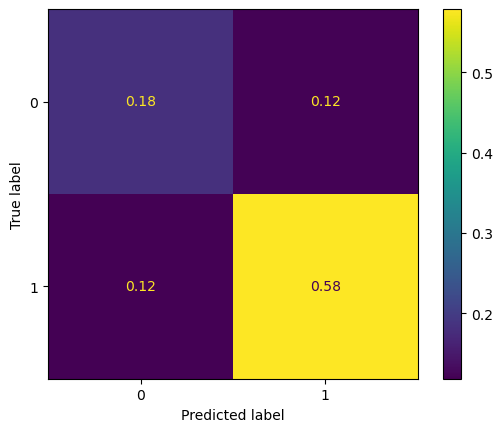

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test, preds7,normalize='all')

### ROC-AUC Curve

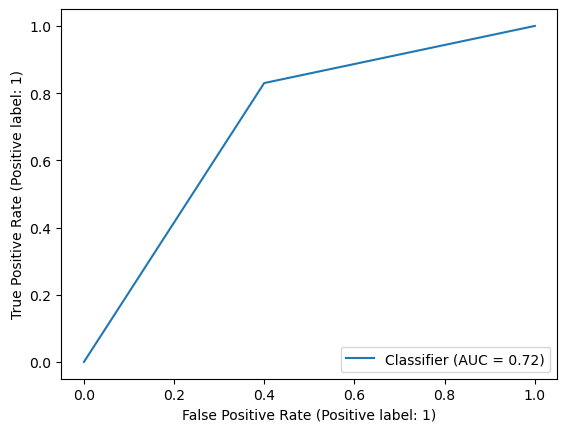

In [141]:
RocCurveDisplay.from_predictions(y_test,preds7)

### Precision-Recall Curve

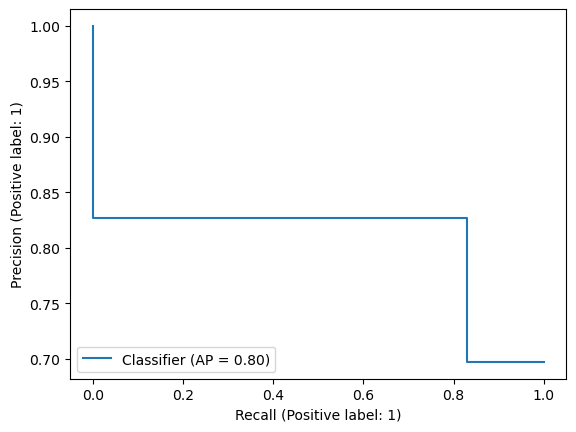

In [142]:
PrecisionRecallDisplay.from_predictions(y_test,preds7)

## XGBoost Model 

In [143]:
from xgboost import XGBClassifier

In [144]:
xgb_pipe = deepcopy(preprocess_pipeline)
xgb_pipe.steps.append(('xgbModel',XGBClassifier(random_state=42)))
xgb_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('xgbModel',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [145]:
xgb_pipe.fit(X_train,y_train)
preds6 = xgb_pipe.predict(X_test)

### Classification Report

In [146]:
print(classification_report(y_test, preds6))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      5229
           1       0.86      0.92      0.89     12043

    accuracy                           0.84     17272
   macro avg       0.82      0.78      0.80     17272
weighted avg       0.83      0.84      0.83     17272



### Confusion Matrix Display

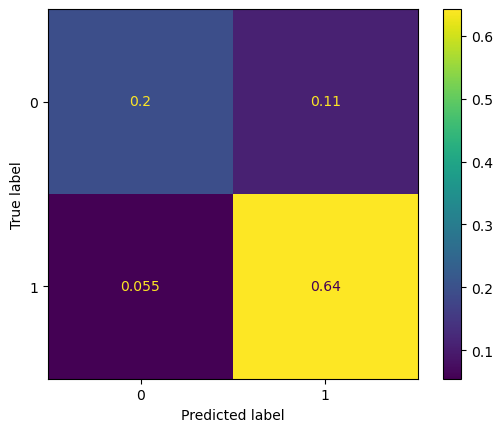

In [147]:
ConfusionMatrixDisplay.from_predictions(y_test, preds6,normalize='all')

### Precision-Recall AUC

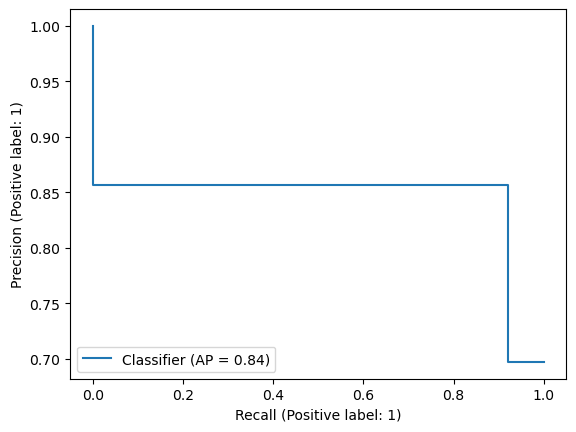

In [148]:
PrecisionRecallDisplay.from_predictions(y_test,preds6)

In [149]:
xgb_params = {'tfdif__min_df':[.01,.03,.05],
              'tfdif__max_df':[.85,.90,.95],
              'xgbModel__max_depth': [3,4, 5], 
              'xgbModel__learning_rate': [.1, .3, .5],
              'xgbModel__gamma': [0,5,10], 
              'xgbModel__n_estimators': [50,100, 150] }

In [150]:
xgb_rcv_pipe = RandomizedSearchCV(estimator=xgb_pipe,
                                  param_distributions=xgb_params,
                                 cv=5)

In [151]:
xgb_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('xgbModel',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importa...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=42, ...))]),
                   param_distributions={'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05],
                                        'xgbModel__gamma': [0, 5, 10],
                                        'xgbModel__learning_rate': [0.1, 0.3,
                                                                    0.5],
                                        'xgbModel__max_depth': [3, 4, 5],
                                        'xgbModel__n_estimators': [50, 100,
                                                                   150]})

In [152]:
best_xgb_preds = xgb_rcv_pipe.predict(X_test)

### Classification Report

In [153]:
print(classification_report(y_test, best_xgb_preds))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65      5229
           1       0.84      0.90      0.87     12043

    accuracy                           0.81     17272
   macro avg       0.78      0.75      0.76     17272
weighted avg       0.80      0.81      0.80     17272



### Confusion Matrix Display

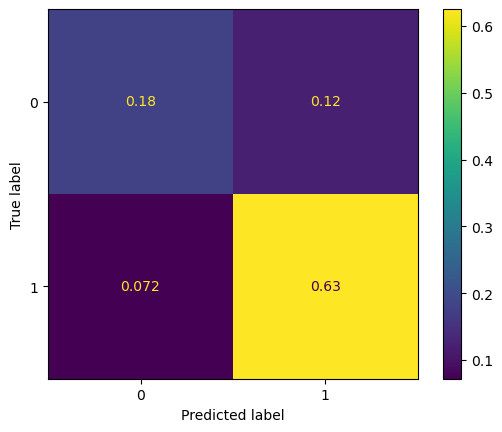

In [154]:
ConfusionMatrixDisplay.from_predictions(y_test, best_xgb_preds,normalize='all')

### ROC-AUC 

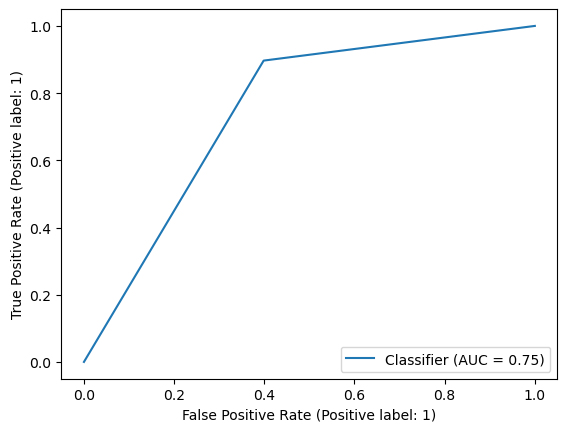

In [155]:
RocCurveDisplay.from_predictions(y_test, best_xgb_preds)

### Precision-Recall AUC

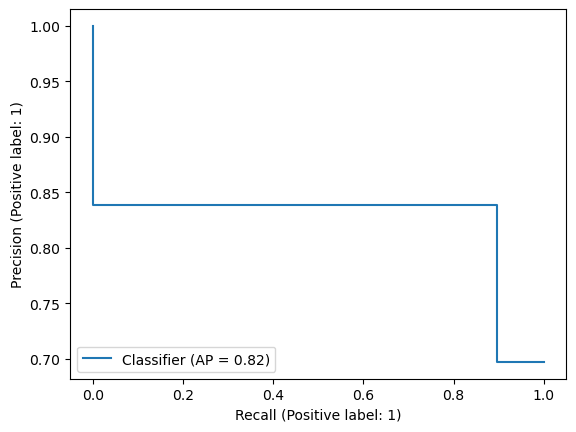

In [156]:
PrecisionRecallDisplay.from_predictions(y_test,best_xgb_preds)

**BEST MODEL**:

Using our evaluation criteria, the best model is a logistic regression without hyperparameter tuning:
- accuracy: .86
- macro_f1_score: .82 

###  Feature Importance (Noun Phrases)

So we've identified that our best model is a `LogisticRegresssion` with default params -- what next? Now that our model can classify the correct sentiment (positive or negative), we need to better understand the **vocabulary** it is using. These latent features will allow us to better understand how we can alter user sentiment and provide and better user experience. 

In [157]:
# using our best estimator extract the vocabulary from the vectorizer used 
words = random_cv.best_estimator_.steps[0][1].vocabulary_

# getting the coefs of each words
word_importance = random_cv.best_estimator_.named_steps['log_reg'].coef_

# zipping them so that we can get the word and corresponding coef 
word_importance = np.unique(word_importance)
important_words = list(zip(words,word_importance))

In [158]:
word_map = [(x,words[x]) for x in words]
word_map.sort(key=lambda x:x[1])

In [159]:
imp_vocab = [x[0] for x in word_map]

# number of unique words models considered as part of their vocabulary 
len(imp_vocab)

239

In [160]:
imp_words = str(imp_vocab)
imp_words = imp_words.replace("\'","").replace("[","").replace("]","").replace(","," ")

In [161]:
from textblob import TextBlob

In [162]:
imp_words_blob = TextBlob(imp_words)
imp_nouns = imp_words_blob.noun_phrases

In [163]:
imp_nouns_list = []
for noun in imp_nouns:
    imp_nouns_list.append(noun.replace(' ','_'))
imp_nouns_str = ' '.join(imp_nouns_list)

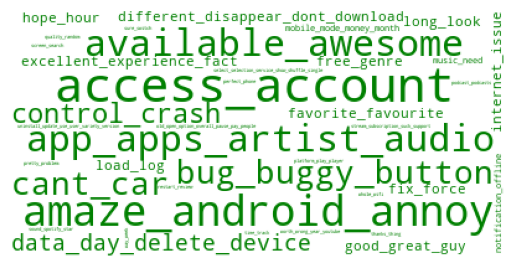

In [164]:
nouns_wc = WordCloud(background_color='white',color_func=lambda *args, **kwargs: "green")
nouns_wc.generate_from_text(imp_nouns_str)
plt.imshow(nouns_wc)
plt.axis('off')
plt.savefig('images/important_noun_phrases.png',dpi=300)

In [165]:
# using these noun phrases our model considered important, 
# lets read some of the reviews that mention "android"
spotify_df[spotify_df.review.str.contains('android')].review.values

array(['this pop-up "get the best spotify experience on android 12" is too annoying. please let\'s get rid of this.',
       'android user - there are loads of glitches with this app... player bar disappears, shuffle button missing....sort it out please',
       'work really well with android auto on those long drives home.',
       ...,
       "unstable app through multiple updates, different devices, android and ios, etc. crashes, freezes, lags, bugs in playback/pause. the irony of frequent premium account upsells during this experience is poignant; do the crashes stop if i pay a monthly fee?! doubtful! if it weren't for the exclusive podcasts, i would abandon spotify altogether. and neverending, pointless recommendations, adds, etc. google/apple podcast apps are superior.",
       "i've had this app for years and it works great on both iphone and android. it's super easy to use and organize. i pay monthly to avoid commercials because it's definitely worth it. there's just no better 

So, we have our important noun phrases that our model considered important when classifying a review as positive or negative. Our next step is to extract the relevant words (or vocabulary) that our model utilized and construct a WordCloud mapping the phrases most salient.

In [166]:
imp_word_coef = list(zip(imp_vocab,word_importance))
correct_df = pd.DataFrame(imp_word_coef, columns=['word', 'coef'])
correct_df.sort_values('coef',ascending=False).head(5)

,word,coef
238,youtube,7.590022
237,year,7.125250
236,wrong,6.685694
235,worth,5.633947
234,work,5.181105


In [167]:
correct_df.sort_values('coef',ascending=False).tail(5)

,word,coef
4,actually,-4.010923
3,account,-4.260612
2,access,-4.418157
1,absolutely,-5.233637
0,able,-5.862684


In [168]:
positive_dict = {x[0]:x[1] for x in imp_word_coef}

In [169]:
from wordcloud import STOPWORDS
stop_wrds = list(STOPWORDS) + ["absolutely","already","actually"]

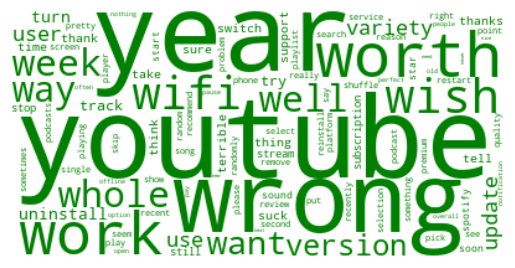

In [170]:
wordcloud = WordCloud(background_color='white',
                      color_func=lambda *args, **kwargs: "green",stopwords=stop_wrds)
wordcloud.generate_from_frequencies(positive_dict)
plt.axis('off')
plt.imshow(wordcloud,interpolation='bilinear')

## Negative Reviews Feature Importance

In [171]:
neg_words = list(zip(imp_vocab,word_importance*-1))
negative_dict = {x[0]:x[1] for x in neg_words}

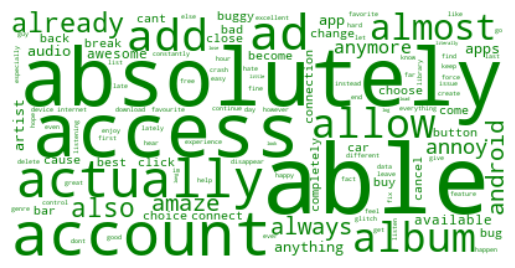

In [172]:
wc = WordCloud(background_color='white',
                      color_func=lambda *args, **kwargs: "green",stopwords=stop_wrds)
wc.generate_from_frequencies(negative_dict)
plt.axis('off')
plt.imshow(wc,interpolation='bilinear')

In [173]:
# creating a dataframe with words and their coefs 
imp_words_df = pd.DataFrame(important_words, columns=['Word', 'Weight'])
imp_words_df.sort_values('Weight',ascending=False).head(10)

,Word,Weight
238,whole,7.590022
237,end,7.125250
236,disappear,6.685694
235,break,5.633947
234,uninstall,5.181105
233,perfect,5.087653
232,lately,5.076917
231,late,4.723050
230,old,4.628679
229,however,4.596922


In [174]:
imp_words_df.sort_values(by='Weight',ascending=False).tail()

,Word,Weight
4,see,-4.010923
3,premium,-4.260612
2,buy,-4.418157
1,ad,-5.233637
0,hate,-5.862684


In [175]:
# top ten words with the highest negative correlation to target label 
# these words have an inverse relationship with classifying a review as positive or negative
imp_words_df.sort_values(by='Weight',ascending=False).tail(10)

,Word,Weight
9,good,-1.801122
8,ever,-2.458001
7,thing,-2.522975
6,app,-3.124673
5,sure,-3.685107
4,see,-4.010923
3,premium,-4.260612
2,buy,-4.418157
1,ad,-5.233637
0,hate,-5.862684


In [176]:
coef_dict = {x[0]:x[1] for x in important_words}

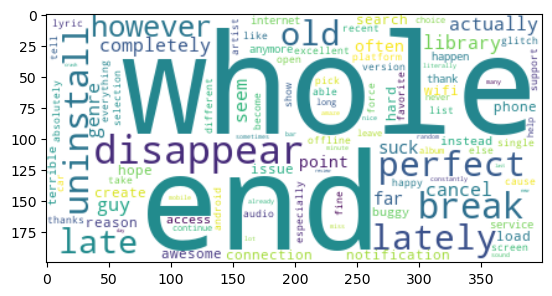

In [177]:
wordcloud = WordCloud(background_color='white')

wordcloud.generate_from_frequencies(coef_dict)
plt.imshow(wordcloud,interpolation='bilinear')

In [178]:
neg_coef_list = list(zip(words,word_importance*-1))
neg_coef_dict = {x[0]:x[1] for x in important_words}

In [179]:
neg_coef_dict

{'hate': -5.862683927394395,
 'ad': -5.233637032627313,
 'buy': -4.418156519779965,
 'premium': -4.2606116167818655,
 'see': -4.010922902232206,
 'sure': -3.685107147473842,
 'app': -3.1246733705136207,
 'thing': -2.522974844806716,
 'ever': -2.4580009865100725,
 'good': -1.801121954651954,
 'apps': -1.7214356807225677,
 'think': -1.4897119229463138,
 'play': -1.4545546585201006,
 'dont': -1.3939600605803146,
 'download': -1.383350599745703,
 'spotify': -1.2511146051065067,
 'well': -1.2436849593653874,
 'listen': -1.1818033816559774,
 'track': -1.1736407369214397,
 'favourite': -1.1464395346690974,
 'connect': -1.109291687118398,
 'year': -1.1029122532482483,
 'add': -0.9785035438321494,
 'skip': -0.9780056983843921,
 'come': -0.8847658174701628,
 'fix': -0.8623353292402,
 'great': -0.808628053359633,
 'enjoy': -0.8042255395370266,
 'also': -0.7687726745514593,
 'free': -0.7670397481762545,
 'month': -0.765677640949402,
 'cant': -0.7574447872471602,
 'even': -0.7321574677639313,
 'son

(-0.5, 399.5, 199.5, -0.5)

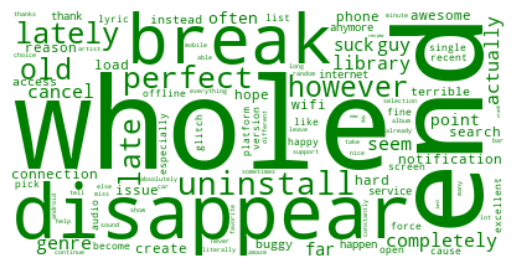

In [180]:
wordcloud = WordCloud(background_color='white', color_func=lambda *args, **kwargs: "green")

wordcloud.generate_from_frequencies(neg_coef_dict)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')